<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/LB_unet_all_20_20_15s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 60 x 5s
* *Output resolution*: 60 x 5s
* *Representation of trajectories* : Matrix Distance and Time series
* *Layers* : convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


## load data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [5]:
data_train = pd.read_csv('./data/LB_train.csv')
data_validation = pd.read_csv('./data/LB_validation.csv')
data_test = pd.read_csv('./data/LB_test.csv')

## choose resolution

In [6]:
resolution = 15

data_train_new = change_resolution(data_train, resolution)
data_validation_new = change_resolution(data_validation, resolution)
data_test_new = change_resolution(data_test, resolution)

data_train_new = standardize_data(data_train_new)
data_validation_new = standardize_data(data_validation_new)
data_test_new = standardize_data(data_test_new)

data_train_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_55_LB_T1,2008-11-25 13:48:16,-77.277228,-11.757092,0.066667,0,12.376541,-2.727183,2.046299,-0.997460,0.699135,0.998867,-0.047580
3,P1108_55_LB_T1,2008-11-25 13:48:31,-77.278858,-11.756507,0.000000,0,12.612815,-29.282468,2.029184,-0.974821,0.712596,0.872219,-0.489116
4,P1108_55_LB_T1,2008-11-25 13:48:46,-77.280625,-11.756392,0.000000,0,12.863682,-16.328379,2.010633,-0.970371,0.726888,0.959666,-0.281142
5,P1108_55_LB_T1,2008-11-25 13:49:01,-77.282367,-11.755687,0.000000,0,13.692604,18.658749,1.992345,-0.943088,0.774114,0.947441,0.319931
6,P1108_55_LB_T1,2008-11-25 13:49:16,-77.284227,-11.755203,0.000000,0,13.981258,-7.595771,1.972815,-0.924381,0.790559,0.991225,-0.132183


## choose window

In [7]:
# Hyperparameters
window = 20
variable = ('lon_std', 'lat_std', 'step_speed_std', 'step_direction_cos', 'step_direction_sin', 'gaps')

train_set = TrajDataSet(data_train_new, window, variable)

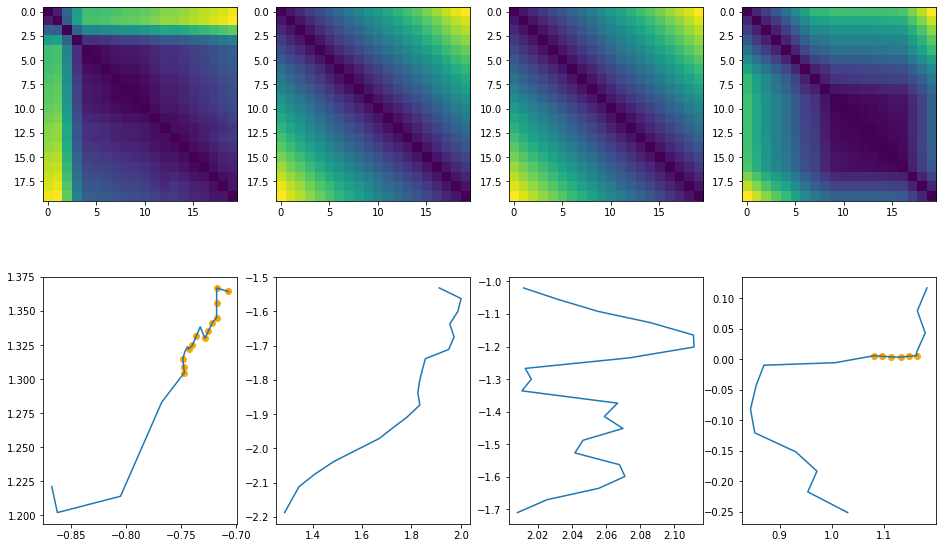

In [8]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, matrix_dist, dive = train_set[i]

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [9]:
# hyperparameters
batch_size = 64

## reduce size dataset
train_set = TrajDataSet(data_train_new, window, variable, transform = ToTensor())
validation_set = TrajDataSet(data_validation_new, window, variable, transform = ToTensor())

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [10]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        self.threshold = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(8+6),
            nn.Conv1d(8+6, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [11]:
# get sample
x, y, z = next(iter(train_loader)) 
weight = torch.FloatTensor([5])

# Forward model
model = UNet()


out = model.threshold(y)
out = torch.sum(out, 2)

out = torch.cat((out, x.squeeze(1)), 1)

out_1 = model.cnn_input_1(out)
out = model.pooling_1(out_1)
out_2 = model.cnn_input_2(out)
out = model.pooling_2(out_2)
out = model.cnn_input_3(out)

out = model.upconv_2(out)
out = torch.cat((out, out_2), 1)
out = model.cnn_output_2(out)

out = model.upconv_1(out)
out = torch.cat((out, out_1), 1)
out = model.cnn_output_1(out)

out.size()

torch.Size([64, 1, 20])

In [12]:
# get sample
x, y, z = next(iter(train_loader)) 
weight = torch.FloatTensor([5])

# Forward model
model = UNet()

out = model(x, y)

# Loss and score
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
criterion(out, z)
get_score(out, z)

(100.0, 0.0)

In [13]:
## get Loss weight
torch.sum(z==z)/torch.sum(z)

tensor(2.4568)

## Training

In [14]:
# switch to GPU
model = UNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
weight = weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [15]:
# Train the model
nb_epoch = 5

global_loss_train = []
global_loss_validation = []
    
for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1
        # send to GPU
        x, y, z = x.to(device), y.to(device), z.to(device)

        # Run the forward pass
        out = model(x, y)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_train.append(loss.item())
            list_score_train.append(score)
        
        train_loss = np.mean(list_loss_train)
        train_trueP = np.mean([tp for (tp, tn) in list_score_train])
        train_trueN = np.mean([tn for (tp, tn) in list_score_train])
            
        k = 0
        # validation
        list_loss_validation = []
        list_score_validation = []
        for batch, (x, y, z) in enumerate(validation_loader):
            k+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)

        validation_loss = np.mean(list_loss_validation)
        validation_trueP = np.mean([tp for (tp, tn) in list_score_validation])
        validation_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}, Train True Positive : {} %, Train True Negative : {} %'
            .format(round(train_loss, 2), round(train_trueP, 2), round(train_trueN, 2)))
    print('Validation Loss: {}, Validation True Positive : {} %, Validation True Negative : {} %'
            .format(round(validation_loss, 2), round(validation_trueP, 2), round(validation_trueN, 2)))
    model.train()
    
    global_loss_train.append(train_loss)
    global_loss_validation.append(validation_loss)

    #### STOP WHEN VALIDATION DECREASE
    if epoch>1:
      if global_loss_validation[-2] < global_loss_validation[-1]:
        break

Epoch [1/5] -------------------------------------------------------------------------------------
Train Loss: 0.62, Train True Positive : 98.42 %, Train True Negative : 80.53 %
Validation Loss: 0.62, Validation True Positive : 97.82 %, Validation True Negative : 81.32 %
Epoch [2/5] -------------------------------------------------------------------------------------
Train Loss: 0.6, Train True Positive : 98.57 %, Train True Negative : 80.86 %
Validation Loss: 0.6, Validation True Positive : 97.96 %, Validation True Negative : 81.46 %
Epoch [3/5] -------------------------------------------------------------------------------------
Train Loss: 0.6, Train True Positive : 98.61 %, Train True Negative : 80.77 %
Validation Loss: 0.6, Validation True Positive : 98.04 %, Validation True Negative : 81.33 %
Epoch [4/5] -------------------------------------------------------------------------------------
Train Loss: 0.6, Train True Positive : 98.6 %, Train True Negative : 80.71 %
Validation Loss:

# Testing

In [16]:
dive_estim = []

for i in data_test_new.trip.unique():
    # create dataset for a trajectory
    t = data_test_new[data_test_new.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_test_new['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

P1109_15_LB_T4
P1109_19_LB_T4
P1111_21_LB_T2
P1111_22_LB_T2
P1111_29_LB_T1
P1111_39_LB_T5
P1113_21_LB_T1
P1113_35_LB_T2


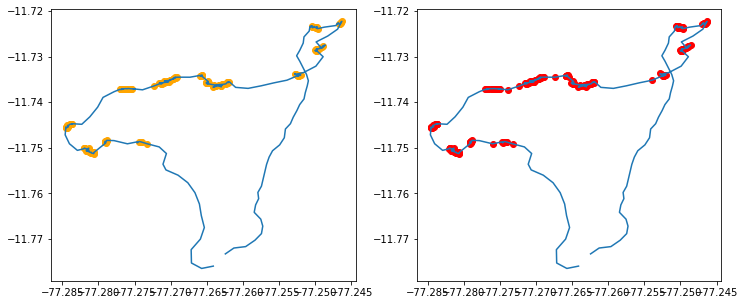

In [17]:
t = data_test_new[data_test_new.trip == 'P1109_15_LB_T4'].copy() 

plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.prediction > 0.5], t.lat[t.prediction > 0.5], c = 'red')

# ROC curve

Change the decision threshold

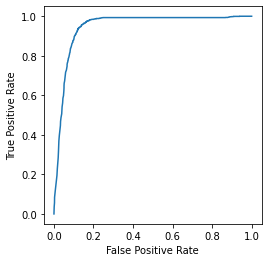

In [18]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test_new.prediction > tt)
    true_positive = np.mean(all_estim[data_test_new.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test_new.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))

# Export Probabilities

In [19]:
data_test_new.to_csv('LB_unet_all_20_20_15s.csv', index = False)